In [1]:
#IMPORTS

import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as kr
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import mnist
import os
import csv

from scipy.spatial.distance import euclidean
from sklearn.metrics import confusion_matrix

from time import sleep
from tqdm import tqdm

import copy
import numpy
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from numpy.random import RandomState
import scipy as scp
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras import backend as K
from itertools import product
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn import mixture

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Enter here the data set you want to explain (adult, activity, or synthatic)

data_set = 'adult'

# Enter here the numb er of peers you want in the experiments

n_peers = 100

In [3]:
# the random state we will use in the experiments. It can be changed 

rs = RandomState(92)

In [4]:
# preprocessing adults data set

if data_set == 'adult':
    #Load dataset into a pandas DataFrame
    adult_data = pd.read_csv('adult_data.csv', na_values='?')
    # Drop all records with missing values
    adult_data.dropna(inplace=True)
    adult_data.reset_index(drop=True, inplace=True)

    # Drop fnlwgt, not interesting for ML
    adult_data.drop('fnlwgt', axis=1, inplace=True)
    adult_data.drop('education', axis=1, inplace=True)

#     merging some similar features.
    adult_data['marital-status'].replace('Married-civ-spouse', 'Married', inplace=True)
    adult_data['marital-status'].replace('Divorced', 'Unmarried', inplace=True)
    adult_data['marital-status'].replace('Never-married', 'Unmarried', inplace=True)
    adult_data['marital-status'].replace('Separated', 'Unmarried', inplace=True)
    adult_data['marital-status'].replace('Widowed', 'Unmarried', inplace=True)
    adult_data['marital-status'].replace('Married-spouse-absent', 'Married', inplace=True)
    adult_data['marital-status'].replace('Married-AF-spouse', 'Married', inplace=True)
    
    adult_data = pd.concat([adult_data,pd.get_dummies(adult_data['income'], prefix='income')],axis=1)
    adult_data.drop('income', axis=1, inplace=True)
    obj_columns = adult_data.select_dtypes(['object']).columns
    adult_data[obj_columns] = adult_data[obj_columns].astype('category')
    # Convert numerics to floats and normalize
    num_columns = adult_data.select_dtypes(['int64']).columns
    adult_data[num_columns] = adult_data[num_columns].astype('float64')
    for c in num_columns:
        #adult[c] -= adult[c].mean()
        #adult[c] /= adult[c].std()
         adult_data[c] = (adult_data[c] - adult_data[c].min()) / (adult_data[c].max()-adult_data[c].min())
    # 'workclass', 'marital-status', 'occupation', 'relationship' ,'race', 'gender', 'native-country'
    # adult_data['income'] = adult_data['income'].cat.codes
    adult_data['marital-status'] = adult_data['marital-status'].cat.codes
    adult_data['occupation'] = adult_data['occupation'].cat.codes
    adult_data['relationship'] = adult_data['relationship'].cat.codes
    adult_data['race'] = adult_data['race'].cat.codes
    adult_data['gender'] = adult_data['gender'].cat.codes
    adult_data['native-country'] = adult_data['native-country'].cat.codes
    adult_data['workclass'] = adult_data['workclass'].cat.codes

    num_columns = adult_data.select_dtypes(['int8']).columns
    adult_data[num_columns] = adult_data[num_columns].astype('float64')
    for c in num_columns:
        #adult[c] -= adult[c].mean()
        #adult[c] /= adult[c].std()
         adult_data[c] = (adult_data[c] - adult_data[c].min()) / (adult_data[c].max()-adult_data[c].min())
    display(adult_data.info())
    display(adult_data.head(10))
    
    adult_data = adult_data.to_numpy()
    
#     splite the data to train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(adult_data[:,:-2],adult_data[:,-2:], test_size=0.07, random_state=rs)
#     the names of the features
    names = ['age','workclass','educational-num','marital-status','occupation',
         'relationship','race','gender','capital-gain','capital-loss','hours-per-week','native-country']
    Features_number = len(X_train[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null float64
workclass          45222 non-null float64
educational-num    45222 non-null float64
marital-status     45222 non-null float64
occupation         45222 non-null float64
relationship       45222 non-null float64
race               45222 non-null float64
gender             45222 non-null float64
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null float64
income_<=50K       45222 non-null uint8
income_>50K        45222 non-null uint8
dtypes: float64(12), uint8(2)
memory usage: 4.2 MB


None

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_<=50K,income_>50K
0,0.109589,0.333333,0.400000,1.0,0.461538,0.6,0.5,1.0,0.000000,0.0,0.397959,0.95,1,0
1,0.287671,0.333333,0.533333,0.0,0.307692,0.0,1.0,1.0,0.000000,0.0,0.500000,0.95,1,0
2,0.150685,0.166667,0.733333,0.0,0.769231,0.0,1.0,1.0,0.000000,0.0,0.397959,0.95,0,1
3,0.369863,0.333333,0.600000,0.0,0.461538,0.0,0.5,1.0,0.076881,0.0,0.397959,0.95,0,1
4,0.232877,0.333333,0.333333,1.0,0.538462,0.2,1.0,1.0,0.000000,0.0,0.295918,0.95,1,0
5,0.630137,0.666667,0.933333,0.0,0.692308,0.0,1.0,1.0,0.031030,0.0,0.316327,0.95,0,1
6,0.095890,0.333333,0.600000,1.0,0.538462,0.8,1.0,0.0,0.000000,0.0,0.397959,0.95,1,0
7,0.520548,0.333333,0.200000,0.0,0.153846,0.0,1.0,1.0,0.000000,0.0,0.091837,0.95,1,0
8,0.657534,0.333333,0.533333,0.0,0.461538,0.0,1.0,1.0,0.064181,0.0,0.397959,0.95,0,1
9,0.260274,0.000000,0.800000,0.0,0.000000,0.0,1.0,1.0,0.000000,0.0,0.397959,0.95,1,0


In [5]:
if data_set == 'synthatic':
    #generate the data
    X, y = make_classification(n_samples=1000000, n_features=10, n_redundant=3, n_repeated=2, #n_classes=3, 
                           n_informative=5, n_clusters_per_class=4, 
                           random_state=42)
    y = pd.DataFrame(data=y, columns=["y"])
    y = pd.get_dummies(y['y'], prefix='y')
    y = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.07, random_state=rs)
    #     the names of the features
    names = ['X(0)','X(1)','X(2)','X(3)','X(4)','X(5)','X(6)','X(7)','X(8)','X(9)']
    Features_number = len(X_train[0])

In [6]:
if data_set == 'activity':
    #Load dataset into a pandas DataFrame
    activity = pd.read_csv("activity_3_original.csv", sep=',')
#      drop some features that have non value in the majority of the samples
    to_drop = ['subject', 'timestamp', 'heart_rate','activityID']
    activity.drop(axis=1, columns=to_drop, inplace=True)
#     prepare the truth
    activity = pd.concat([activity,pd.get_dummies(activity['motion'], prefix='motion')],axis=1)
    activity.drop('motion', axis=1, inplace=True)
    class_label = [ 'motion_n', 'motion_y']
    predictors = [a for a in activity.columns.values if a not in class_label]

    for p in predictors:
        activity[p].fillna(activity[p].mean(), inplace=True)

    display(predictors)
    for p in predictors:
        activity[p] = (activity[p]-activity[p].min()) / (activity[p].max() - activity[p].min())
        activity[p].astype('float32')
    activity = activity.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(activity[:,:-2],activity[:,-2:], test_size=0.07, random_state=rs)
    #     the names of the features
    names = ['temp_hand','acceleration_16_x_hand',
        'acceleration_16_y_hand','acceleration_16_z_hand','acceleration_6_x_hand',
        'acceleration_6_y_hand','acceleration_6_z_hand','gyroscope_x_hand','gyroscope_y_hand',
        'gyroscope_z_hand','magnetometer_x_hand','magnetometer_y_hand','magnetometer_z_hand',
        'temp_chest','acceleration_16_x_chest','acceleration_16_y_chest','acceleration_16_z_chest','acceleration_6_x_chest',
        'acceleration_6_y_chest','acceleration_6_z_chest','gyroscope_x_chest','gyroscope_y_chest','gyroscope_z_chest',
        'magnetometer_x_chest','magnetometer_y_chest','magnetometer_z_chest','temp_ankle','acceleration_16_x_ankle',
        'acceleration_16_y_ankle','acceleration_16_z_ankle','acceleration_6_x_ankle','acceleration_6_y_ankle',
        'acceleration_6_z_ankle','gyroscope_x_ankle','gyroscope_y_ankle','gyroscope_z_ankle','magnetometer_x_ankle',
        'magnetometer_y_ankle','magnetometer_z_ankle']
    Features_number = len(X_train[0])


In [7]:
#begin federated

earlystopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0.01,
                              patience = 50,
                              verbose = 1,
                              baseline = 2,
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('test.h8',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
    
model = Sequential()
model.add(Dense(70, input_dim=Features_number, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, y_train,
epochs=2,
validation_data=(X_test, y_test),
callbacks = [checkpoint, earlystopping],
shuffle=True)

Train on 42056 samples, validate on 3166 samples
Epoch 1/2
42056/42056 [==============================] - ETA: 2:15 - loss: 0.7931 - accuracy: 0.28 - ETA: 5s - loss: 0.5651 - accuracy: 0.6988 - ETA: 3s - loss: 0.5165 - accuracy: 0.72 - ETA: 2s - loss: 0.4896 - accuracy: 0.74 - ETA: 2s - loss: 0.4646 - accuracy: 0.76 - ETA: 2s - loss: 0.4489 - accuracy: 0.77 - ETA: 1s - loss: 0.4412 - accuracy: 0.77 - ETA: 1s - loss: 0.4316 - accuracy: 0.78 - ETA: 1s - loss: 0.4258 - accuracy: 0.78 - ETA: 1s - loss: 0.4224 - accuracy: 0.79 - ETA: 1s - loss: 0.4158 - accuracy: 0.79 - ETA: 1s - loss: 0.4118 - accuracy: 0.79 - ETA: 1s - loss: 0.4073 - accuracy: 0.80 - ETA: 1s - loss: 0.4052 - accuracy: 0.80 - ETA: 1s - loss: 0.4025 - accuracy: 0.80 - ETA: 1s - loss: 0.3992 - accuracy: 0.80 - ETA: 1s - loss: 0.3983 - accuracy: 0.80 - ETA: 0s - loss: 0.3964 - accuracy: 0.80 - ETA: 0s - loss: 0.3930 - accuracy: 0.80 - ETA: 0s - loss: 0.3893 - accuracy: 0.81 - ETA: 0s - loss: 0.3881 - accuracy: 0.81 - ETA: 0s 

In [8]:
#AUXILIARY METHODS FOR FEDERATED LEARNING

# RETURN INDICES TO LAYERS WITH WEIGHTS AND BIASES
def trainable_layers(model):
    return [i for i, layer in enumerate(model.layers) if len(layer.get_weights()) > 0]

# RETURN WEIGHTS AND BIASES OF A MODEL
def get_parameters(model):
    weights = []
    biases = []
    index = trainable_layers(model)
    for i in index:
        weights.append(copy.deepcopy(model.layers[i].get_weights()[0]))
        biases.append(copy.deepcopy(model.layers[i].get_weights()[1]))           
    
    return weights, biases
        
# SET WEIGHTS AND BIASES OF A MODEL
def set_parameters(model, weights, biases):
    index = trainable_layers(model)
    for i, j in enumerate(index):
        model.layers[j].set_weights([weights[i], biases[i]])
    
# DEPRECATED: RETURN THE GRADIENTS OF THE MODEL AFTER AN UPDATE 
def get_gradients(model, inputs, outputs):
    """ Gets gradient of model for given inputs and outputs for all weights"""
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    
    w_grad = [w for i,w in enumerate(output_grad) if i%2==0]
    b_grad = [w for i,w in enumerate(output_grad) if i%2==1]
    
    return w_grad, b_grad

# RETURN THE DIFFERENCE OF MODELS' WEIGHTS AND BIASES AFTER AN UPDATE 
# NOTE: LEARNING RATE IS APPLIED, SO THE UPDATE IS DIFFERENT FROM THE
# GRADIENTS. IN CASE VANILLA SGD IS USED, THE GRADIENTS ARE OBTAINED
# AS (UPDATES / LEARNING_RATE)
def get_updates(model, inputs, outputs, batch_size, epochs):
    w, b = get_parameters(model)
    #model.train_on_batch(inputs, outputs)
    model.fit(inputs, outputs, batch_size=batch_size, epochs=epochs, verbose=0)
    w_new, b_new = get_parameters(model)
    
    weight_updates = [old - new for old,new in zip(w, w_new)]
    bias_updates = [old - new for old,new in zip(b, b_new)]
    
    return weight_updates, bias_updates

# UPDATE THE MODEL'S WEIGHTS AND PARAMETERS WITH AN UPDATE
def apply_updates(model, eta, w_new, b_new):
    w, b = get_parameters(model)
    new_weights = [theta - eta*delta for theta,delta in zip(w, w_new)]
    new_biases = [theta - eta*delta for theta,delta in zip(b, b_new)]
    set_parameters(model, new_weights, new_biases)
    
# FEDERATED AGGREGATION FUNCTION
def aggregate(n_layers, n_peers, f, w_updates, b_updates):
    agg_w = [f([w_updates[j][i] for j in range(n_peers)], axis=0) for i in range(n_layers)]
    agg_b = [f([b_updates[j][i] for j in range(n_peers)], axis=0) for i in range(n_layers)]
    return agg_w, agg_b

# SOLVE NANS
def nans_to_zero(W, B):
    W0 = [np.nan_to_num(w, nan=0.0, posinf=0.0, neginf=0.0) for w in W]
    B0 = [np.nan_to_num(b, nan=0.0, posinf=0.0, neginf=0.0) for b in B]
    return W0, B0

def build_forest(X,y):
    clf=RandomForestClassifier(n_estimators=1000, max_depth=7, random_state=0, verbose = 1)
    clf.fit(X,y)
    return clf

# COMPUTE EUCLIDEAN DISTANCE OF WEIGHTS
def dist_weights(w_a, w_b):
    wf_a = flatten_weights(w_a)
    wf_b = flatten_weights(w_b)
    return euclidean(wf_a, wf_b)

# TRANSFORM ALL WEIGHT TENSORS TO 1D ARRAY
def flatten_weights(w_in):
    h = w_in[0].reshape(-1)
    for w in w_in[1:]:
        h = np.append(h, w.reshape(-1))
    return h
    

In [9]:
# scan the forest for trees maches the wrong predictions of the black-box
def scan_wrong(forest_predictions, FL_predict1, forest , y_test_local, X_test_local):
    sum_feature_improtance= 0
    overal_wrong_feature_importance = 0
    counter = 0
    second_counter = 0
    never_seen = 0
    avr_wrong_importance = 0
    FL_predict1 = np.argmax(FL_predict1, axis=1)
    forest_predictions = np.argmax(forest_predictions, axis=1)
    y_test_local = np.argmax(y_test_local, axis=1)
    for i in range (len(FL_predict1)):
        i_tree = 0
#         if the black-box got a wrong prediction
        if (FL_predict1[i] != y_test_local[i]):
#         getting the prediction of the trees one by one
            for tree_in_forest in forest.estimators_:
                sample = X_test_local[i].reshape(1, -1)
                temp = forest.estimators_[i_tree].predict(sample)
                temp =  np.argmax(temp, axis=1)
                i_tree = i_tree + 1
#  if the prediction of the tree maches the predictions of the black-box
                if(FL_predict1[i] == temp):
#         getting the features importances
                    sum_feature_improtance = sum_feature_improtance + tree_in_forest.feature_importances_
                    counter = counter + 1
#         if we have trees maches the black-box predictions
        if(counter>0):
            ave_feature_importence = sum_feature_improtance/counter
            overal_wrong_feature_importance = ave_feature_importence + overal_wrong_feature_importance
            second_counter = second_counter + 1
            counter = 0
            sum_feature_improtance = 0
#             if there is no trees maches the black-box predictions
        else:
            if(FL_predict1[i] != y_test_local[i]):
                never_seen = never_seen +1
#                 getting the average features importances for all the samples that had wrong predictions.
    if(second_counter>0):
        avr_wrong_importance = overal_wrong_feature_importance / second_counter
    return forest.feature_importances_

In [10]:
trainable_layers(model)

[0, 1, 2, 3]

In [11]:
get_parameters(model)

([array([[ 1.39432400e-01,  8.84631574e-02, -4.47415888e-01,
           1.23670131e-01, -2.65049934e-01,  2.56673127e-01,
           2.82177985e-01, -3.88451487e-01, -8.48813355e-02,
          -4.55360711e-01, -2.55180508e-01, -1.34169891e-01,
          -4.19932574e-01,  9.50885192e-02, -4.10533138e-02,
           1.23161055e-01, -3.34913731e-01, -3.29331495e-02,
          -2.09537312e-01,  2.89370805e-01, -2.42182449e-01,
           9.41318497e-02, -8.54814351e-02, -2.53278345e-01,
           7.38841221e-02,  9.76254940e-02,  9.64644551e-03,
           4.62163612e-02,  1.47847623e-01,  3.28071006e-02,
          -2.16738522e-01, -5.52587435e-02, -1.01704948e-01,
           2.31297538e-01, -3.01694840e-01,  2.23755836e-02,
          -2.37541839e-01, -8.33741352e-02, -3.33046556e-01,
          -3.82800475e-02, -2.60576427e-01,  1.35413051e-01,
           5.84374070e-02, -1.67372033e-01,  7.50956163e-02,
          -2.44477212e-01,  4.34608996e-01,  1.95100769e-01,
          -1.71157598e-0

In [12]:
get_updates(model, X_train, y_train, 32, 2)

([array([[ 1.49011612e-06, -1.16565228e-02,  7.42741823e-02,
           1.84727460e-02, -8.54203105e-03, -1.07147992e-02,
          -1.21345818e-02,  7.30311871e-02, -9.66983289e-03,
           6.97897077e-02,  3.34345400e-02,  8.74996185e-05,
           8.57096016e-02,  1.60385072e-02,  1.19651444e-02,
           2.49370933e-03,  8.43369067e-02,  1.64110810e-02,
           2.05034018e-02, -1.07030272e-02,  1.41942352e-02,
           8.08978826e-03,  3.21836621e-02,  5.65186143e-02,
          -4.39171195e-02,  4.30863351e-03, -1.15206484e-02,
           2.10180618e-02, -7.25415349e-03,  3.23727727e-06,
          -3.62303257e-02,  1.32649988e-02,  6.42685592e-03,
           1.92415118e-02,  3.42182815e-02,  1.04672834e-02,
           0.00000000e+00,  2.78882086e-02,  4.19589877e-02,
          -2.18840521e-02,  9.14855003e-02,  4.81577218e-03,
          -5.83276898e-03,  1.10103935e-02, -1.27351061e-02,
           1.04498863e-02, -4.18264568e-02,  2.71596760e-02,
           2.05704421e-0

In [13]:
W = get_parameters(model)[0]
B = get_parameters(model)[1]

In [14]:
# BASELINE SCENARIO
#buid the model as base line for the shards (sequential)
# Number of peers
#accordin to what we need
ss = int(len(X_train)/n_peers)
inputs_in = X_train[0*ss:0*ss+ss]
outputs_in = y_train[0*ss:0*ss+ss]
def build_model(X_t, y_t):
    model = Sequential()
    model.add(Dense(70, input_dim=Features_number, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.fit(X_t,
              y_t,        
              batch_size=32, 
              epochs=250, 
              verbose=1,
              validation_data=((X_test, y_test)))
    return model


In [15]:
display(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 70)                910       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 7,112
Trainable params: 7,112
Non-trainable params: 0
_________________________________________________________________


None

In [16]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

In [17]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print('F1 score: %f' % f1)

Accuracy: 0.836071
Precision: 0.791075
Recall: 0.483871
F1 score: 0.600462


array([[2257,  103],
       [ 416,  390]], dtype=int64)

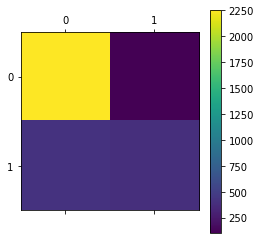

In [18]:
# confusion matrix
mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

display(mat)
plt.matshow(mat);
plt.colorbar()
plt.show()


In [19]:
# the dectinary
FI_dic1= {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}



In [ ]:
# select aa random peer to be the scanner peer
peers_selected=random.sample(range(n_peers), 1)
scaner = peers_selected[0]

# Percentage and number of peers participating at each global training epoch
percentage_participants = 1.0
n_participants = int(n_peers * percentage_participants)

# Number of global training epochs
n_rounds = 10
start_attack_round = 4
end_attack_round = 7
# Number of local training epochs per global training epoch
n_local_rounds = 5

# Local batch size
local_batch_size = 32

# Local learning rate
local_lr = 0.001

# Global learning rate or 'gain'
model_substitution_rate = 1.0

# Attack detection / prevention mechanism = {None, 'distance', 'median', 'accuracy', 'krum'}
discard_outliers = None

# Used in 'dist' attack detection, defines how far the outliers are (1.5 is a typical value)
tau = 1.5

# Used in 'accuracy' attack detection, defines the error margin for the accuracy improvement
sensitivity = 0.05

# Used in 'krum' attack detection, defines how many byzantine attackers we want to defend against
tolerance=4

# Prevent suspicious peers from participating again, only valid for 'dist' and 'accuracy'
ban_malicious = False

# Clear nans and infinites in model updates
clear_nans = True

number_for_threshold1 = numpy.empty(20, dtype=float)
number_for_threshold2 = numpy.empty(20, dtype=float)
for r in range(len(number_for_threshold1)):
    number_for_threshold1[r] = 0
    number_for_threshold2[r] = 0

########################
# ATTACK CONFIGURATION #
########################

# Percentage of malicious peers
r_malicious_peers = 0.0

# Number of malicious peers (absolute or relative to total number of peers)
n_malicious_peers = int(n_peers * r_malicious_peers)
#n_malicious_peers = 1

# Malicious peers
malicious_peer = range(n_malicious_peers)

# Target for coalitions
common_attack_target = [4,7]

# Target class of the attack, per each malicious peer
malicious_targets = dict([(p, t) for p,t in zip(malicious_peer, [common_attack_target]*n_malicious_peers)])

# Boosting parameter per each malicious peer
common_malicious_boost = 12
malicious_boost = dict([(p, b) for p,b in zip(malicious_peer, [common_malicious_boost]*n_malicious_peers)])

###########
# METRICS #
###########
metrics = {'accuracy': [],
          'atk_effectivity': [],
          'update_distances': [],
          'outliers_detected': [],

          'acc_no_target': []}

####################################
# MODEL AND NETWORK INITIALIZATION #
####################################
inputs = X_train[0*ss:0*ss+ss]
outputs = y_train[0*ss:0*ss+ss]
global_model = build_model(inputs,outputs)
n_layers = len(trainable_layers(global_model))

print('Initializing network.')
sleep(1)
network = []
for i in tqdm(range(n_peers)):
    ss = int(len(X_train)/n_peers)
    inputs = X_train[i*ss:i*ss+ss]
    outputs = y_train[i*ss:i*ss+ss]
#     network.append(build_model(inputs, outputs))
    network.append(global_model)


banned_peers = set()

##################
# BEGIN TRAINING #
##################
for t in range(n_rounds):
    print(f'Round {t+1}.')
    sleep(1)

    ## SERVER SIDE #################################################################
    # Fetch global model parameters
    global_weights, global_biases = get_parameters(global_model)

    if clear_nans:
        global_weights, global_biases = nans_to_zero(global_weights, global_biases)

    # Initialize peer update lists
    network_weight_updates = []
    network_bias_updates = []

    # Selection of participant peers in this global training epoch
    if ban_malicious:
        good_peers = list([p for i,p in enumerate(network) if i not in banned_peers])
        n_participants = n_participants if n_participants <= len(good_peers) else int(len(good_peers) * percentage_participants)
        participants = random.sample(list(enumerate(good_peers)), n_participants)
    else:
        participants = random.sample(list(enumerate(network)),n_participants)
    ################################################################################


    ## CLIENT SIDE #################################################################
    for i, local_model in tqdm(participants):

        # Update local model with global parameters 
        set_parameters(local_model, global_weights, global_biases)

        # Initialization of user data
        ss = int(len(X_train)/n_peers)
        inputs = X_train[i*ss:i*ss+ss]
        outputs = y_train[i*ss:i*ss+ss]

# the scanner peer side
        if(i == scaner):
            X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(inputs,outputs, test_size=0.7, random_state=rs)
            inputs = X_train_local
            outputs = y_train_local
            if(t == 0):
                forest = build_forest(X_train_local,y_train_local)
            forest_predictions = forest.predict(X_test_local)
            acc_forest = np.mean([t==p for t,p in zip(y_test_local, forest_predictions)])
            FL_predict1 = global_model.predict(X_test_local)
            imp = scan_wrong(forest_predictions, FL_predict1, forest , y_test_local, X_test_local)
            FI_dic1[t] = imp


 # Benign peer
                # Train local model 
        local_weight_updates, local_bias_updates = get_updates(local_model, 
                                                                       inputs, outputs, 
                                                                       local_batch_size, n_local_rounds)
        if clear_nans:
            local_weight_updates, local_bias_updates = nans_to_zero(local_weight_updates, local_bias_updates)
        network_weight_updates.append(local_weight_updates)
        network_bias_updates.append(local_bias_updates)

    ## END OF CLIENT SIDE ##########################################################

    ######################################
    # SERVER SIDE AGGREGATION MECHANISMS #
    ######################################


        # Aggregate client updates
    aggregated_weights, aggregated_biases = aggregate(n_layers, 
                                                      n_participants, 
                                                      np.mean, 
                                                      network_weight_updates, 
                                                      network_bias_updates)

    if clear_nans:
        aggregated_weights, aggregated_biases = nans_to_zero(aggregated_weights, aggregated_biases)

    # Apply updates to global model
    apply_updates(global_model, model_substitution_rate, aggregated_weights, aggregated_biases)

    # Proceed as in first case
    aggregated_weights, aggregated_biases = aggregate(n_layers, 
                                                      n_participants, 
                                                      np.mean, 
                                                      network_weight_updates, 
                                                      network_bias_updates)
    if clear_nans:
        aggregated_weights, aggregated_biases = nans_to_zero(aggregated_weights, aggregated_biases)

    apply_updates(global_model, model_substitution_rate, aggregated_weights, aggregated_biases)

    ###################
    # COMPUTE METRICS #
    ###################

    # Global model accuracy
    score = global_model.evaluate(X_test, y_test, verbose=0)
    print(f'Global model loss: {score[0]}; global model accuracy: {score[1]}')
    metrics['accuracy'].append(score[1])


    # Accuracy without the target
    score = global_model.evaluate(X_test, y_test, verbose=0)
    metrics['acc_no_target'].append(score[1])


    # Distance of individual updates to the final aggregation
    metrics['update_distances'].append([dist_weights(aggregated_weights, w_i) for w_i in network_weight_updates])



Train on 420 samples, validate on 3166 samples
Epoch 1/250
420/420 [==============================] - ETA: 1s - loss: 0.8020 - accuracy: 0.15 - 0s 475us/step - loss: 0.6159 - accuracy: 0.6571 - val_loss: 0.5505 - val_accuracy: 0.7454
Epoch 2/250
420/420 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.81 - 0s 221us/step - loss: 0.5195 - accuracy: 0.7667 - val_loss: 0.5165 - val_accuracy: 0.7454
Epoch 3/250
420/420 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.78 - 0s 197us/step - loss: 0.4819 - accuracy: 0.7667 - val_loss: 0.4850 - val_accuracy: 0.7454
Epoch 4/250
420/420 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.78 - 0s 202us/step - loss: 0.4604 - accuracy: 0.7667 - val_loss: 0.4648 - val_accuracy: 0.7454
Epoch 5/250
420/420 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.81 - 0s 216us/step - loss: 0.4435 - accuracy: 0.7690 - val_loss: 0.4511 - val_accuracy: 0.7527
Epoch 6/250
420/42

420/420 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.90 - 0s 211us/step - loss: 0.2671 - accuracy: 0.8643 - val_loss: 0.3861 - val_accuracy: 0.8152
Epoch 45/250
420/420 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.96 - 0s 211us/step - loss: 0.2889 - accuracy: 0.8738 - val_loss: 0.3877 - val_accuracy: 0.8234
Epoch 46/250
420/420 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.84 - 0s 220us/step - loss: 0.2635 - accuracy: 0.8738 - val_loss: 0.3914 - val_accuracy: 0.8222
Epoch 47/250
 32/420 [=>............................] - ETA: 0s - loss: 0.2366 - accuracy: 0.9062

In [ ]:
# sort the feature according to the last epoch and print it with importances

sort_index = np.argsort(FI_dic1[9])
for x in sort_index:
    print(names[x], ', ', FI_dic1[9][x])